# Going to start fresh and clean data first

In [1]:
# Imports
import sys
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
import datetime
import geopandas as gpd
import sklearn

import warnings
warnings.filterwarnings('ignore')

#networkx graph computing library
import networkx as nx

#opensourcemap networkx geopandas library
import osmnx as ox

# to create Point objects that can be used with the GeoDataFrame.contains(Point) boolean method
from shapely.geometry import Point

import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

train_path = '/Users/trystenhess/Desktop/CS/internshipPENN/project_stuff/penn_env/psi_protocol/ny_dataset/train.csv'
man_filter_path = '/Users/trystenhess/Desktop/CS/internshipPENN/project_stuff/penn_env/psi_protocol/ny_dataset/contained_in_man.csv'

Only want Manhattan for right now, decrease sample size, still very large.

In [2]:
train = pd.read_csv(train_path)
manhattan_filter = pd.read_csv(man_filter_path, names=['in_man'])
train = train[manhattan_filter['in_man']]

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1232404 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1232404 non-null  object 
 1   vendor_id           1232404 non-null  int64  
 2   pickup_datetime     1232404 non-null  object 
 3   dropoff_datetime    1232404 non-null  object 
 4   passenger_count     1232404 non-null  int64  
 5   pickup_longitude    1232404 non-null  float64
 6   pickup_latitude     1232404 non-null  float64
 7   dropoff_longitude   1232404 non-null  float64
 8   dropoff_latitude    1232404 non-null  float64
 9   store_and_fwd_flag  1232404 non-null  object 
 10  trip_duration       1232404 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 112.8+ MB


latitude is y-val


longitude is x-val

In [4]:
train['distance'] = train.apply(lambda x: ox.distance.great_circle_vec(x.pickup_latitude, x.pickup_longitude, x.dropoff_latitude, x.dropoff_longitude), axis=1)

In [5]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1498.522897
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1805.509719
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6385.107515
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1485.500521
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1188.590138


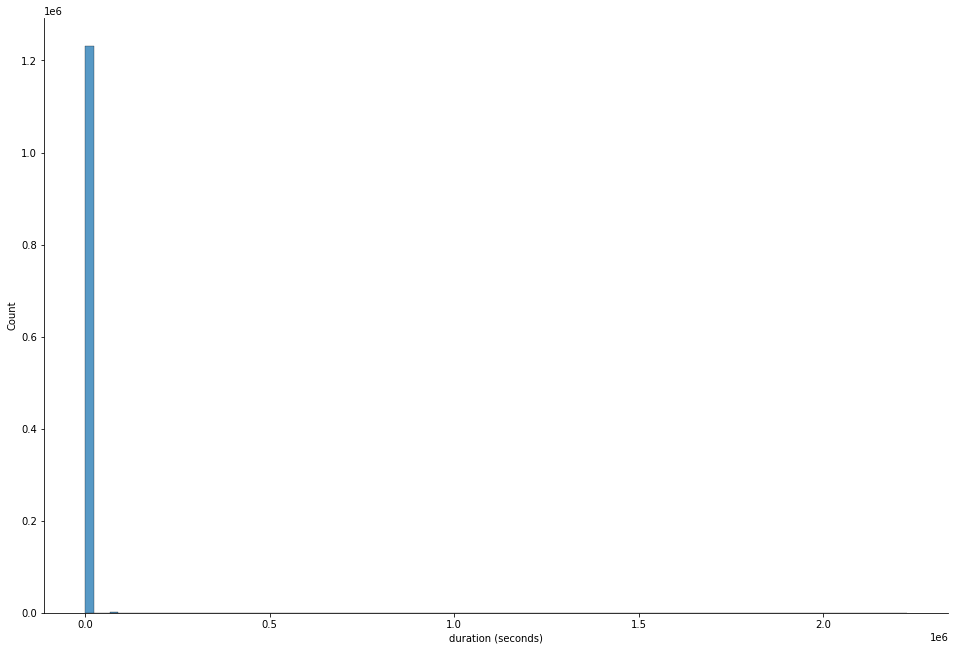

In [7]:
ax = sns.displot(train['trip_duration'].values, bins = 100)
ax.fig.set_size_inches(15,10)
ax.set(xlabel='duration (seconds)')

We can see that the data is bunched up closer to 0, but anomalies seem to be stretching out the graph, must handle these before working with the data

Using the average speed of 3.17 m/s in Manhattan, I took the length of Manhattan, 21565.21 meters, found that it would take less than two hours, 1.889 hours, 6802.9 seconds on average to get across the city.

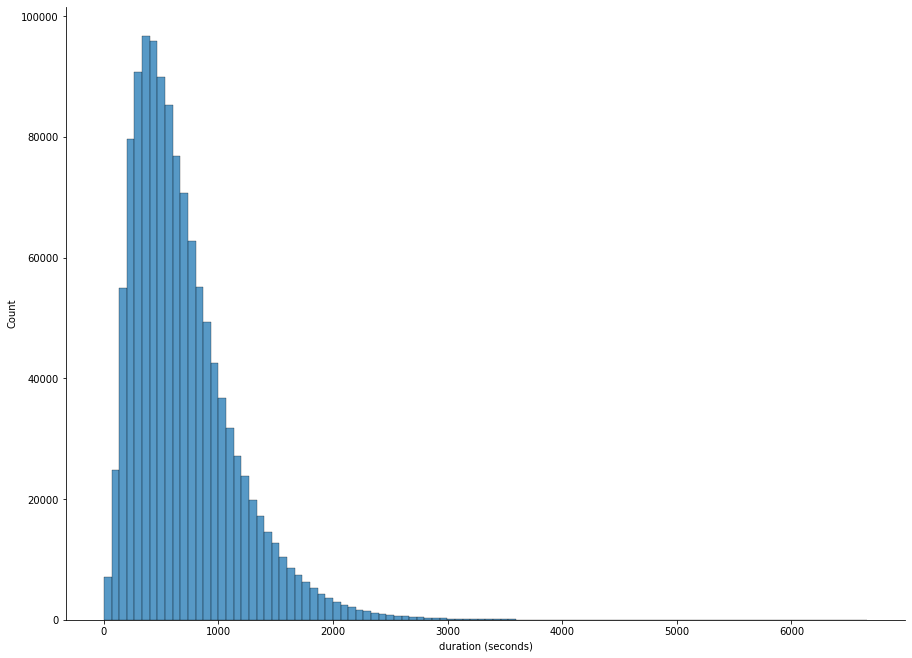

In [27]:
ax = sns.displot(train['trip_duration'][train['trip_duration']<=6802.9], bins = 100)
ax.set(xlabel='duration (seconds)')
ax.fig.set_size_inches(15,10)

# Idea: Use general direction of travel to determine matchmaking, and use geographical ordering with direction to then match rides

# If one ride starts on left side of map, then goes right, and another ride starts further right, but also goes right, and the start of route 2 isn't too far from the general path of route 1, then this may be a good match

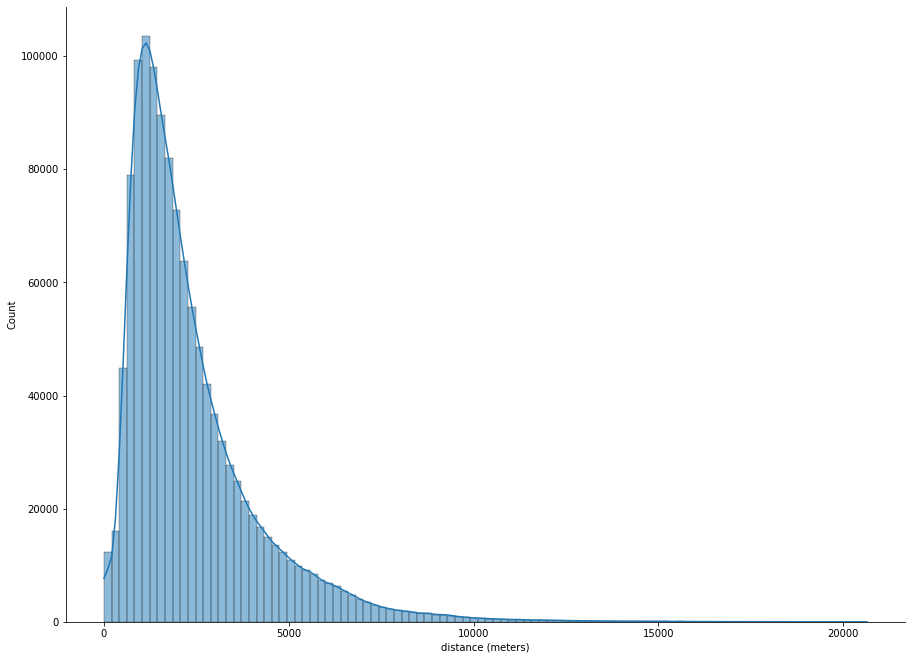

In [9]:
ax = sns.displot(train['distance'], bins = 100, kde=True)
ax.set(xlabel='distance (meters)')
ax.fig.set_size_inches(15,10)

Going to make the trips less than or equal to the length of Manhattan, 13.4 miles = 21565.21 meters

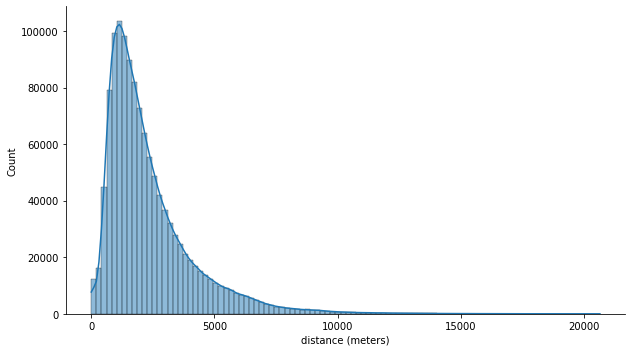

In [13]:
df_filtered = train[train['distance']<=21565.21].copy()
ax = sns.displot(df_filtered['distance'], bins = 100, kde=True)
ax.set(xlabel='distance (meters)')
ax.fig.set_size_inches(10,5)

# Anomaly detection with sklearn

[Text(0.5, 0, 'distance (meters)'), Text(0, 0.5, 'trip_duration (seconds)')]

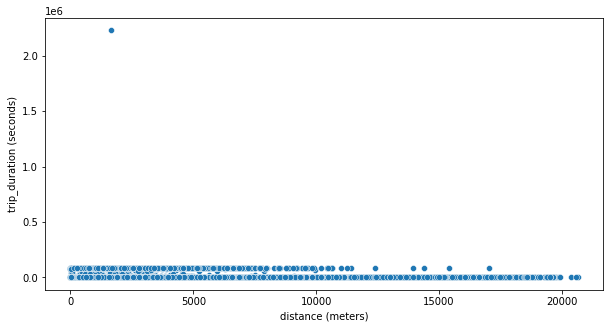

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.scatterplot(data=train, x="distance", y="trip_duration")
ax.set(xlabel='distance (meters)', ylabel='trip_duration (seconds)')

In [17]:
# assuming an anomaly is one that drives across all 13.
print("******************************")
print("Ratio of anamolous distances: ")
print((len(train)-len(train[train['distance']<=21565.21]))/len(train))
print("******************************")
print("******************************")
print("Ratio of anamolous trip durations: ")
print((len(train) - len(train[train['trip_duration']<=6802.91]))/len(train))
print("******************************")

******************************
Ratio of anamolous distances: 
0.0
******************************
******************************
Ratio of anamolous trip durations: 
0.0013875320106069113
******************************


In [28]:
clf = IsolationForest(random_state = 42, contamination = 0.01)
train['Anomaly'] = clf.fit_predict(train[['distance', 'trip_duration']])
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,Anomaly
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1498.522897,1
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1805.509719,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6385.107515,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1485.500521,1
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1188.590138,1


In [29]:
train.Anomaly.value_counts()

 1    1220092
-1      12312
Name: Anomaly, dtype: int64

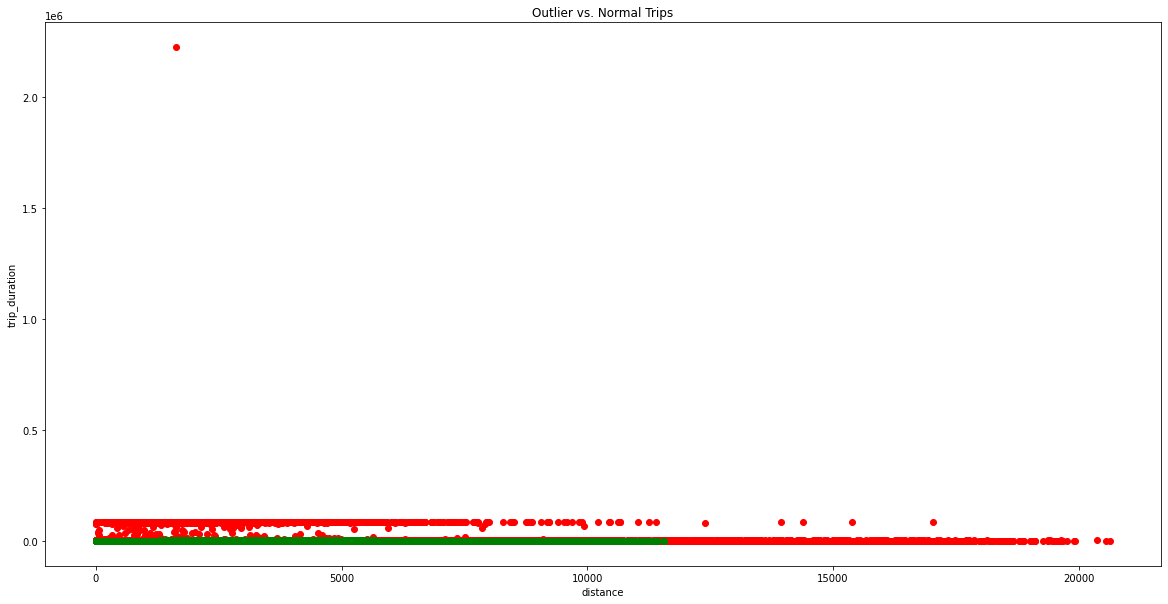

In [30]:
fig, ax = plt.subplots(figsize=(20,10))

plt.title("Outlier vs. Normal Trips")

plt.scatter(train.loc[train.Anomaly == -1, ['distance']], 
                 train.loc[train.Anomaly == -1, ['trip_duration']], c='red')
plt.scatter(train.loc[train.Anomaly == 1, ['distance']], 
                 train.loc[train.Anomaly == 1, ['trip_duration']], c='green')
plt.xlabel("distance")
plt.ylabel("trip_duration")
plt.show()

In [23]:
max(train['trip_duration'])

2227612